- Data source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation


 IMPORT LIBRARIES AND DATASETS

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/MyDrive/Colab Notebooks/AI/Healthcare AI Datasets/Brain_MRI

/content/drive/MyDrive/Colab Notebooks/AI/Healthcare AI Datasets/Brain_MRI


In [7]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [8]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [9]:
brain_df.head(5)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


PERFORM DATA VISUALIZATION

In [10]:
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
...,...,...,...,...
3924,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...,0
3925,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...,0
3926,TCGA_DU_6401_19831001,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...,0
3927,TCGA_DU_6401_19831001,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...,0


In [13]:
brain_df['mask'].value_counts() #unbalanced data, 0 is healty 1 is tumor

0    2556
1    1373
Name: mask, dtype: int64

In [12]:
brain_df['mask'].value_counts().index 

Int64Index([0, 1], dtype='int64')

In [ ]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

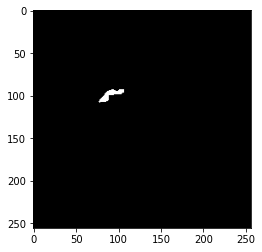

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

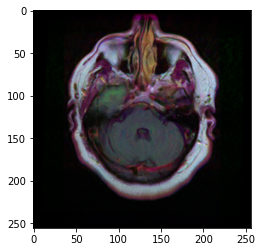

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [ ]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [ ]:
cv2.imread(brain_df.mask_path[623]).min()

0

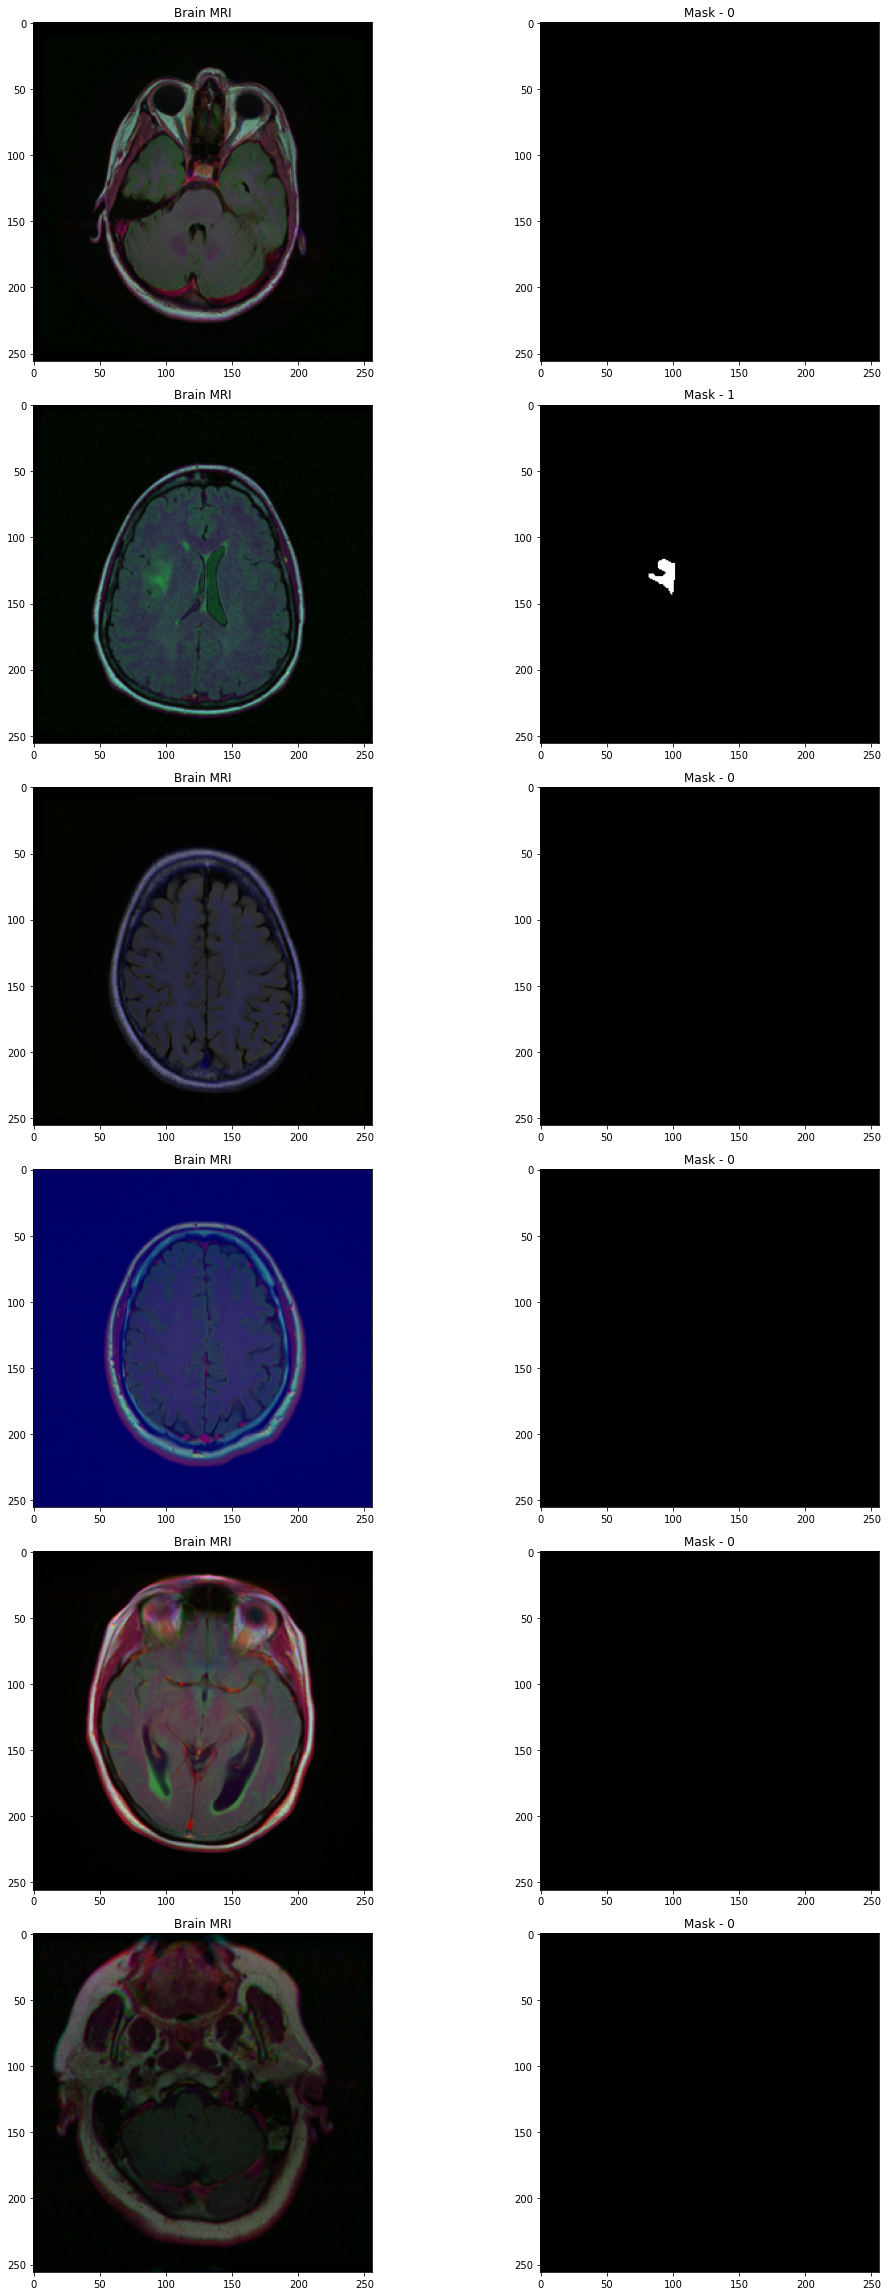

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

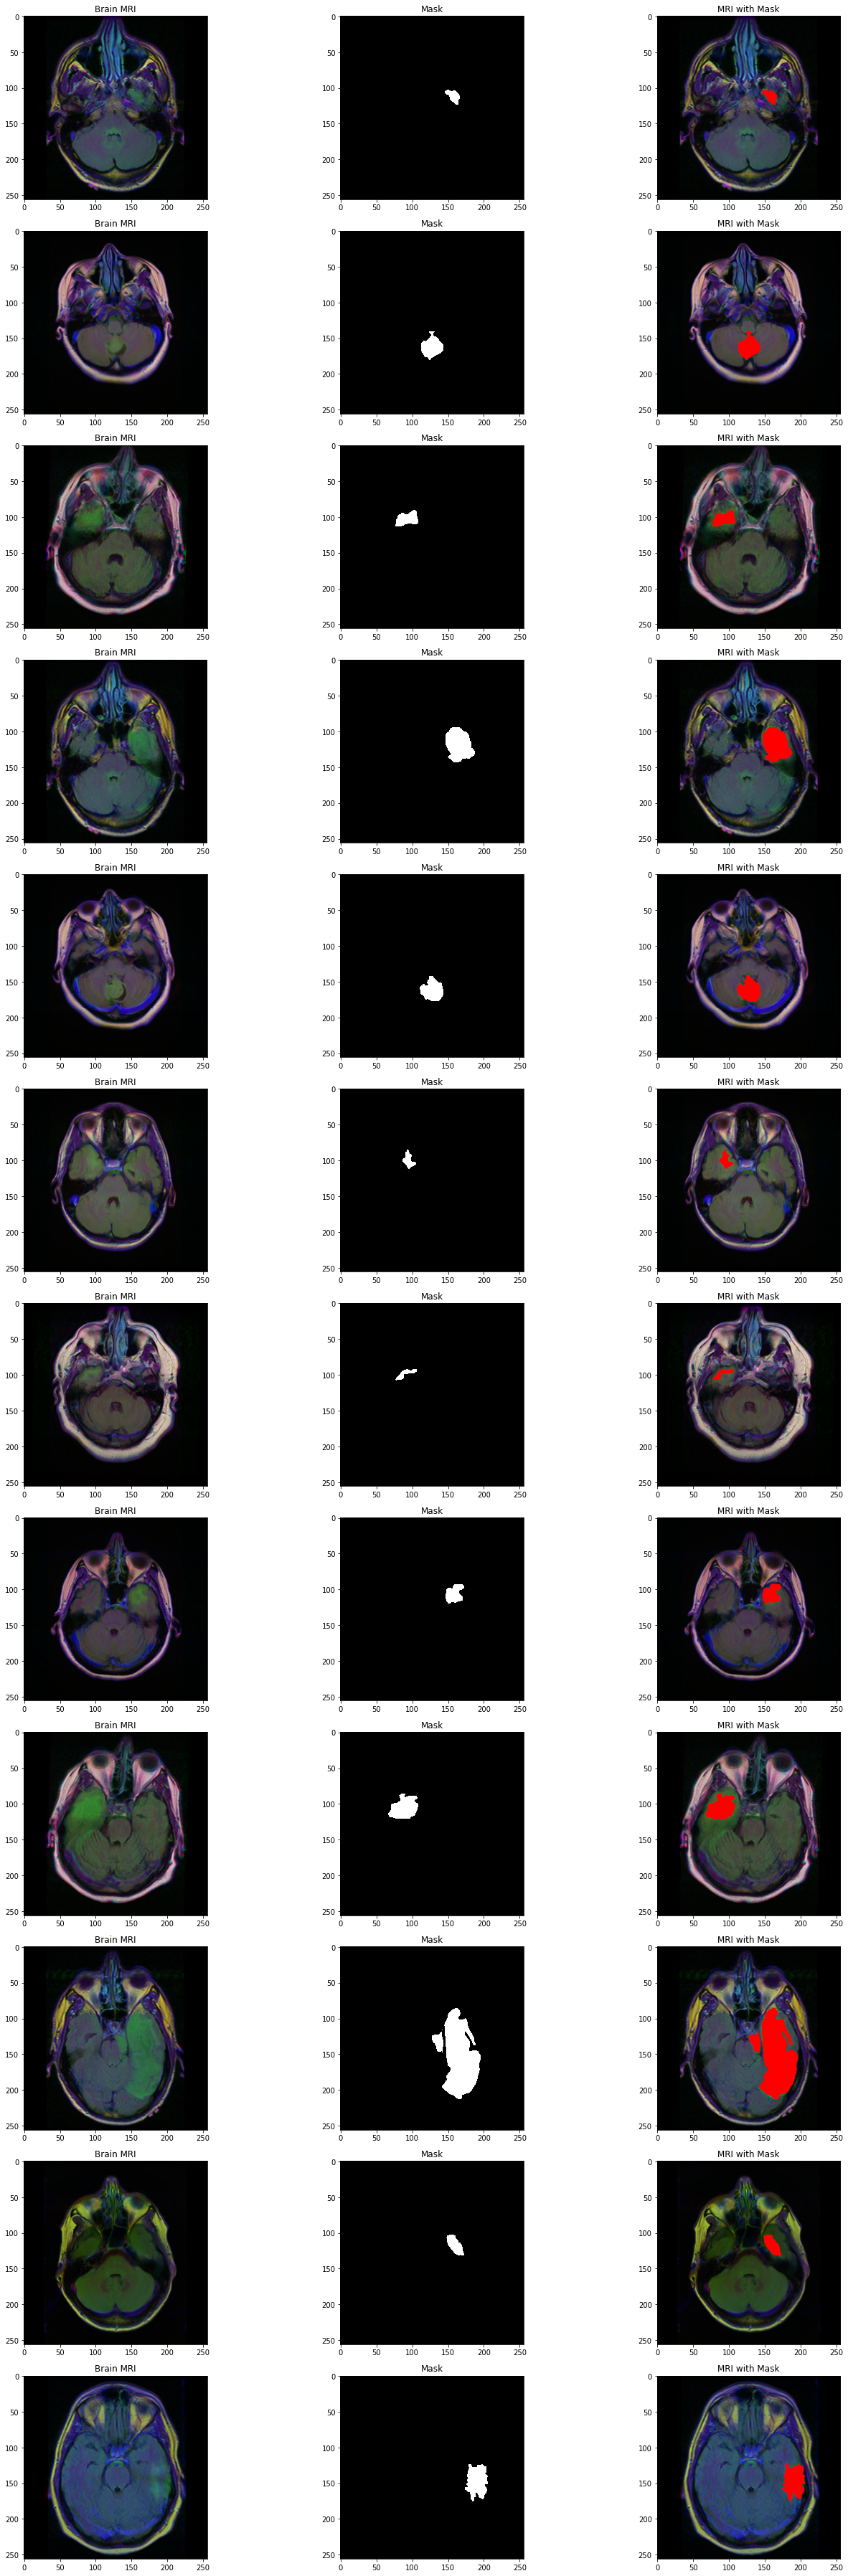

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS AND TRANSFER LEARNİNG-RESNETS 

-  https://arxiv.org/pdf/1512.03385.pdf

- https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
- Article by Jason Brownlee: https://machinelearningmastery.com/transfer-learning-for-deep-learning/

 TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [ ]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=64,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=64,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=64,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = GlobalMaxPooling2D()(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(1024, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)#
headmodel = Dense(512, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(124, activation = "relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator,steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 3.4688 - accuracy: 0.6490 
Epoch 00001: val_loss improved from inf to 2.37331, saving model to classifier-resnet-weights.hdf5
44/44 [==============================] - 677s 15s/step - loss: 3.4688 - accuracy: 0.6490 - val_loss: 2.3733 - val_accuracy: 0.6808
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 0.9116 - accuracy: 0.7216
Epoch 00002: val_loss did not improve from 2.37331
44/44 [==============================] - 37s 833ms/step - loss: 0.9116 - accuracy: 0.7216 - val_loss: 1371.2125 - val_accuracy: 0.6853
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 0.4479 - accuracy: 0.8346
Epoch 00003: val_loss improved from 2.37331 to 1.42820, saving model to classifier-resnet-weights.hdf5
44/44 [==============================] - 41s 925ms/step - loss: 0.4479 - accuracy: 0.8346 - val_loss: 1.4282 - val_accuracy: 0.6808
Epoch 4/50
44/44 [==============================] - ETA: 0s - loss

In [ ]:
#save and load the model
#model.save("eniyisonuç.h5")
model = tf.keras.models.load_model('eniyisonuç.h5')

In [ ]:
# It can be used to reconstruct the model identically.
model.load_weights('classifier-resnet-weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

TRAINED MODEL PERFORMANCE

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 64, verbose =1)

9/9 [==============================] - 111s 12s/step


In [ ]:
test_predict.shape

(576, 2)

In [ ]:
test_predict

array([[9.9999464e-01, 5.3124932e-06],
       [2.0459689e-08, 1.0000000e+00],
       [1.9813357e-04, 9.9980193e-01],
       ...,
       [9.9784040e-01, 2.1596118e-03],
       [8.7627107e-01, 1.2372886e-01],
       [7.6573759e-01, 2.3426242e-01]], dtype=float32)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '1', '1', '0', '0', '1', '1', '1', '1', '1', '0', '0', '1',
       '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1',
       '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0',
       '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0',
       '1', '0', '1', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1',
       '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0',
       '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0',
       '1', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0',
       '0', '0', '0', '1', '1', '1', '0', '0', '1', '1', '0', '0', '0',
       '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9340277777777778

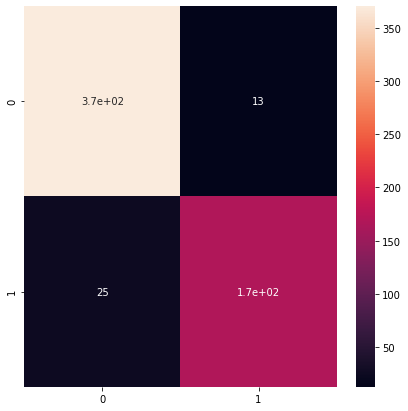

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
_, acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=0)
print('Test Accuracy: %.3f' % (acc * 100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test Accuracy: 93.390


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       383
           1       0.93      0.87      0.90       193

   micro avg       0.93      0.93      0.93       576
   macro avg       0.93      0.92      0.92       576
weighted avg       0.93      0.93      0.93       576



/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:565: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

